# Sentiment Analysis with RNN and LSTM

## Overview
In this notebook, we'll implement sentiment analysis on Trump tweets using both RNN and LSTM models. We'll go through the following steps:

1. Data Preprocessing & Cleaning
2. Tokenization & Padding
3. Model Building (RNN & LSTM)
4. Training & Evaluation
5. Visualization
6. GUI Implementation for Real-Time Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install contractions

## 1. Data Preprocessing & Cleaning

First, let's import the necessary libraries and load the dataset.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud
import contractions

# Download nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Level 6/AI & ML/Worksheets/Worksheet-9/trum_tweet_sentiment_analysis.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Check column names and data types
print("\nColumn information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check the distribution of sentiment labels
if 'label' in df.columns:
    print("\nSentiment label distribution:")
    print(df['label'].value_counts())

    # Visualize the class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment (0=Negative, 1=Positive)')
    plt.ylabel('Count')
    plt.show()

Dataset shape: (1850123, 2)

First 5 rows:


,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850123 entries, 0 to 1850122
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   Sentiment  int64 
dtypes: int64(1), object(1)
memory usage: 28.2+ MB
None

Missing values:
text         0
Sentiment    0
dtype: int64


### Text Cleaning Functions

Let's define functions for text cleaning, including lowercasing, removing URLs, handling contractions, removing special characters, and more.

In [ ]:
def lower_order(text):
    """
    Convert text to lowercase.
    """
    return text.lower()

def remove_urls(text):
    """
    Remove URLs from text.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emoji(string):
    """
    Remove emojis from text.
    """
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def expand_contractions(text):
    """
    Expand contractions (e.g., don't -> do not)
    """
    return contractions.fix(text)

def removeunwanted_characters(document):
    """
    Remove unwanted characters, mentions, hashtags, etc.
    """
    # Remove user mentions
    document = re.sub("@[A-Za-z0-9_]+", " ", document)
    # Remove hashtags (keep the word but remove #)
    document = re.sub("#", "", document)
    # Remove numbers
    document = re.sub("\d+", "", document)
    # Remove punctuation
    document = re.sub("[^A-Za-z ]", "", document)
    # Remove emojis
    document = remove_emoji(document)
    # Remove double spaces
    document = re.sub(r'\s+', ' ', document)
    return document.strip()

def remove_stopwords(tokens):
    """
    Remove stopwords from tokenized text.
    """
    stop_words = set(stopwords.words('english'))
    custom_stopwords = ['rt', '@', 'amp']
    stop_words.update(custom_stopwords)
    return [token for token in tokens if token not in stop_words]

def lemmatization(tokens):
    """
    Lemmatize tokenized text.
    """
    wordnet = WordNetLemmatizer()
    return [wordnet.lemmatize(token, pos='v') for token in tokens]

def text_cleaning_pipeline(text):
    """
    Complete text cleaning pipeline.
    """
    # Lowercase the text
    text = lower_order(text)
    # Expand contractions
    text = expand_contractions(text)
    # Remove URLs
    text = remove_urls(text)
    # Remove unwanted characters
    text = removeunwanted_characters(text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = remove_stopwords(tokens)
    # Lemmatize
    tokens = lemmatization(tokens)
    # Join back into a string
    return " ".join(tokens)

In [ ]:
# Apply the cleaning pipeline to the text column
print("Cleaning the text data...")
df['cleaned_text'] = df['text'].apply(text_cleaning_pipeline)

# Display some examples of original vs cleaned text
comparison_df = pd.DataFrame({
    'Original Text': df['text'].iloc[:5],
    'Cleaned Text': df['cleaned_text'].iloc[:5]
})
comparison_df

Cleaning the text data...


,Original Text,Cleaned Text
0,RT @JohnLeguizamo: #trump not draining swamp b...,trump drain swamp taxpayer dollars trip advert...
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,icymi hackers rig fm radio station play antitr...
2,Trump protests: LGBTQ rally in New York https:...,trump protest lgbtq rally new york bbcworld via
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",hi piers morgan david beckham awful donald tru...
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,tech firm sue buzzfeed publish unverified trum...


### Visualize the cleaned data with Word Cloud

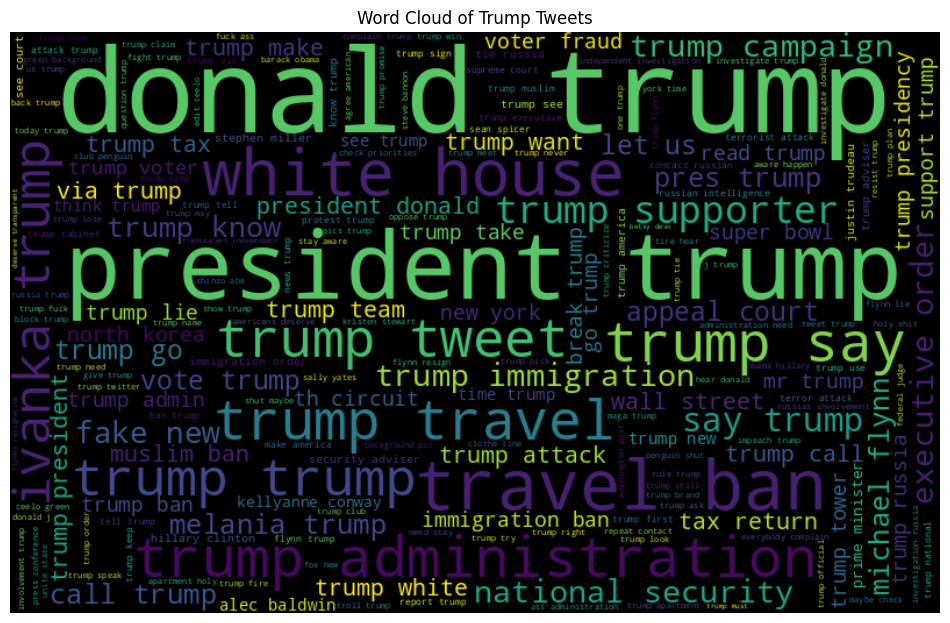

In [ ]:
# Concatenate all cleaned texts
all_words = ' '.join(df['cleaned_text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Trump Tweets')
plt.show()

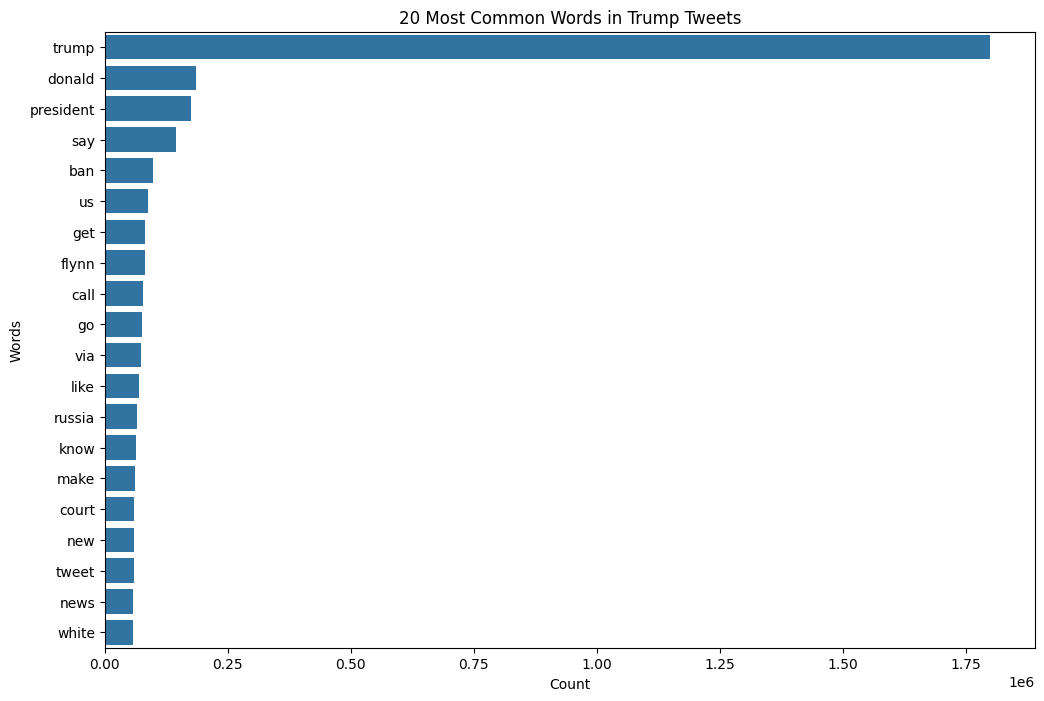

In [ ]:
# Extract most frequent words
from collections import Counter

# Collect all words from the cleaned texts
all_words_list = ' '.join(df['cleaned_text']).split()

# Count the frequencies
word_counts = Counter(all_words_list)

# Display the 20 most common words
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

# Create a bar plot of the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title('20 Most Common Words in Trump Tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

## 2. Tokenization & Padding

Now let's split the data into train and test sets, then tokenize and pad the sequences.

In [21]:
# Split the data into train and test sets (80% train, 20% test)
X = df['cleaned_text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 1480098 samples
Testing set: 370025 samples


In [22]:
# Initialize and fit tokenizer on training data
max_vocab_size = 10000  # Limit vocabulary size
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Get the word index
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)} words")
print(f"Top 10 words: {list(word_index.items())[:10]}")

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Find a sensible sequence length (95th percentile)
seq_lengths = [len(seq) for seq in train_sequences]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Max sequence length (95th percentile): {max_len}")

# Pad the sequences
X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Display shapes
print(f"Padded training data shape: {X_train_pad.shape}")
print(f"Padded testing data shape: {X_test_pad.shape}")

Vocabulary size: 166966 words
Top 10 words: [('<OOV>', 1), ('trump', 2), ('donald', 3), ('president', 4), ('say', 5), ('ban', 6), ('us', 7), ('get', 8), ('flynn', 9), ('call', 10)]
Max sequence length (95th percentile): 14
Padded training data shape: (1480098, 14)
Padded testing data shape: (370025, 14)


## 3. Model Building

Now, let's create two models: a Simple RNN model and an LSTM model.

In [23]:
# Define the embedding parameters
embedding_dim = 128
rnn_units = 64

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

### Simple RNN Model

In [24]:
# Build the Simple RNN model
rnn_model = Sequential([
    # Embedding layer
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_len),
    # SimpleRNN layer
    SimpleRNN(units=rnn_units),
    # Dropout to prevent overfitting
    Dropout(0.3),
    # Output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
rnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model summary
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### LSTM Model

In [25]:
# Build the LSTM model
lstm_model = Sequential([
    # Embedding layer
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_len),
    # LSTM layer
    LSTM(units=rnn_units),
    # Dropout to prevent overfitting
    Dropout(0.3),
    # Output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model summary
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Training & Evaluation

Now let's train both models and evaluate their performance.

### Training the Simple RNN Model

In [26]:
# Train the RNN model
print("Training the Simple RNN model...")
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Training the Simple RNN model...
Epoch 1/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 521s 14ms/step - accuracy: 0.9076 - loss: 0.2304 - val_accuracy: 0.9478 - val_loss: 0.1439
Epoch 2/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 527s 14ms/step - accuracy: 0.9517 - loss: 0.1358 - val_accuracy: 0.9513 - val_loss: 0.1385
Epoch 3/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 550s 14ms/step - accuracy: 0.9573 - loss: 0.1222 - val_accuracy: 0.9511 - val_loss: 0.1390
Epoch 4/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 547s 14ms/step - accuracy: 0.9591 - loss: 0.1177 - val_accuracy: 0.9518 - val_loss: 0.1463
Epoch 5/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 503s 14ms/step - accuracy: 0.9596 - loss: 0.1171 - val_accuracy: 0.9506 - val_loss: 0.1410


### Training the LSTM Model

In [27]:
# Train the LSTM model
print("Training the LSTM model...")
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Training the LSTM model...
Epoch 1/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 718s 19ms/step - accuracy: 0.9168 - loss: 0.2093 - val_accuracy: 0.9556 - val_loss: 0.1237
Epoch 2/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 749s 19ms/step - accuracy: 0.9607 - loss: 0.1095 - val_accuracy: 0.9621 - val_loss: 0.1078
Epoch 3/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 734s 20ms/step - accuracy: 0.9699 - loss: 0.0853 - val_accuracy: 0.9643 - val_loss: 0.1014
Epoch 4/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 715s 19ms/step - accuracy: 0.9753 - loss: 0.0712 - val_accuracy: 0.9654 - val_loss: 0.1029
Epoch 5/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 746s 20ms/step - accuracy: 0.9787 - loss: 0.0619 - val_accuracy: 0.9661 - val_loss: 0.1034
Epoch 6/10
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 798s 20ms/step - accuracy: 0.9811 - loss: 0.0550 - val_accuracy: 0.9665 - val_loss: 0.1054


### Evaluating the Simple RNN Model

RNN Test Accuracy: 0.9514
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step


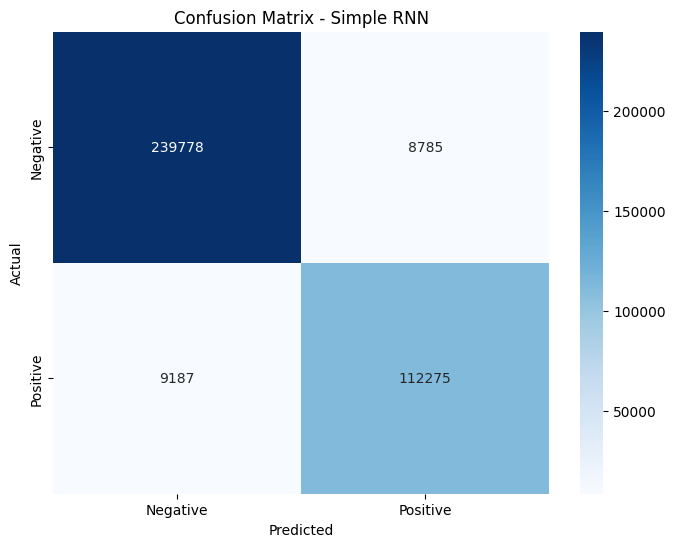


Classification Report - Simple RNN:
              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96    248563
    Positive       0.93      0.92      0.93    121462

    accuracy                           0.95    370025
   macro avg       0.95      0.94      0.94    370025
weighted avg       0.95      0.95      0.95    370025



In [28]:
# Evaluate the RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"RNN Test Accuracy: {rnn_accuracy:.4f}")

# Make predictions
y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")

# Generate confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Simple RNN')
plt.show()

# Print classification report
print("\nClassification Report - Simple RNN:")
print(classification_report(y_test, y_pred_rnn, target_names=['Negative', 'Positive']))

### Evaluating the LSTM Model

LSTM Test Accuracy: 0.9648
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step


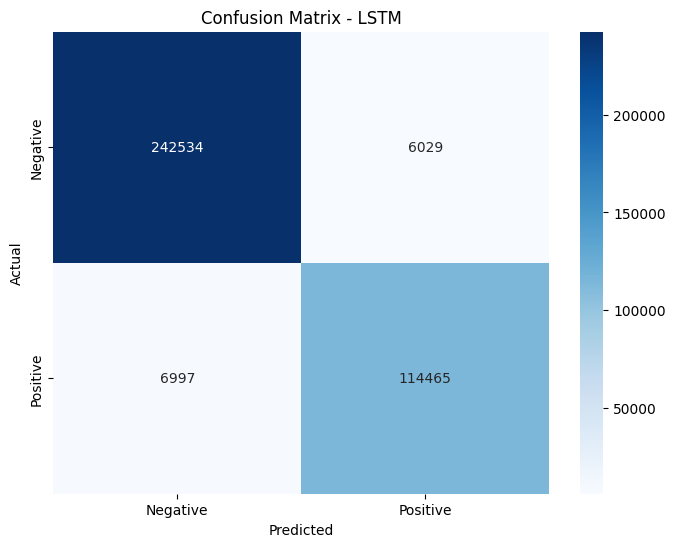


Classification Report - LSTM:
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97    248563
    Positive       0.95      0.94      0.95    121462

    accuracy                           0.96    370025
   macro avg       0.96      0.96      0.96    370025
weighted avg       0.96      0.96      0.96    370025



In [29]:
# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")

# Make predictions
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Generate confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

# Print classification report
print("\nClassification Report - LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Positive']))

## 5. Visualization

Let's compare the performance of both models.

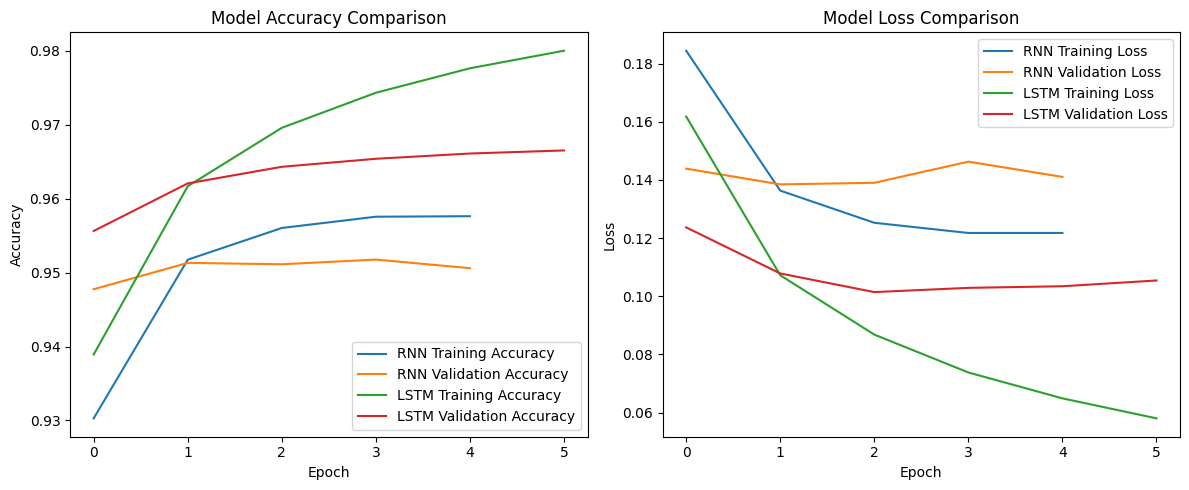

In [30]:
# Plot training & validation accuracy for both models
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

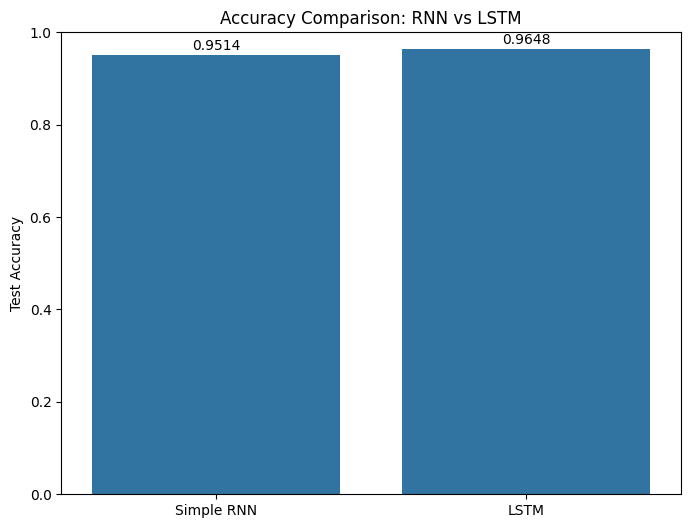

In [31]:
# Compare final accuracies
models = ['Simple RNN', 'LSTM']
accuracies = [rnn_accuracy, lstm_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Accuracy Comparison: RNN vs LSTM')
plt.ylabel('Test Accuracy')
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.01, f'{acc:.4f}', ha='center')
plt.ylim(0, 1.0)
plt.show()

## 6. GUI for Real-Time Prediction

Creating a simple interface using Gradio for real-time predictions.

In [32]:
# Install gradio if not already installed
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.4 MB/s eta 0:00:00


In [35]:
import gradio as gr

def predict_sentiment(tweet, model_choice):
    """
    Function to predict the sentiment of a given tweet using the selected model.
    """
    # Clean the tweet
    cleaned_tweet = text_cleaning_pipeline(tweet)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_tweet])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Make prediction based on model choice
    if model_choice == "Simple RNN":
        prediction = rnn_model.predict(padded_sequence)[0][0]
    else:  # LSTM
        prediction = lstm_model.predict(padded_sequence)[0][0]

    # Convert prediction to sentiment and confidence
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, float(confidence), cleaned_tweet

# Create the Gradio interface
demo = gr.Interface(
    fn=predict_sentiment,
    inputs=[
        gr.Textbox(lines=3, placeholder="Enter a tweet here..."),
        gr.Radio(["Simple RNN", "LSTM"], label="Select Model")
    ],
    outputs=[
        gr.Label(label="Prediction"),
        gr.Number(label="Confidence"),
        gr.Textbox(label="Cleaned Text")
    ],
    title="Trump Tweet Sentiment Analysis",
    description="Enter a tweet to predict its sentiment using RNN or LSTM models",
    examples=[
        ["I love how President Trump is handling the economy! Great job! #MAGA", "LSTM"],
        ["Trump's policies are ruining our country and dividing people.", "LSTM"],
        ["Just heard Trump's speech today. Very impressive and presidential.", "Simple RNN"],
        ["Can't believe the media bias against Trump. So unfair!", "Simple RNN"]
    ]
)

# Launch the interface
demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://464775976f8603052f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Using existing dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://464775976f8603052f.gradio.live
